In [1]:
import pickle
from functools import partial
import pandas as pd
import numpy as np
from scipy import optimize
from scipy.stats import spearmanr
from sklearn.metrics import matthews_corrcoef, precision_score, accuracy_score, roc_auc_score

In [2]:
def read_fasta(fastafile):
    """Parse a file with sequences in FASTA format and store in a dict"""
    with open(fastafile, 'r') as f:
        content = [l.strip() for l in f.readlines()]

    res = {}
    seq, seq_id = '', None
    for line in content:
        if line.startswith('>'):
            
            if len(seq) > 0:
                res[seq_id] = seq
            
            seq_id = line.replace('>', '')
            seq = ''
        else:
            seq += line
    res[seq_id] = seq
    return res

In [4]:
import pandas as pd 
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np

FASTA_FILE = "../Datasets/PSI_Biology/pET_full_without_his_tag.fa"
LABELS_FILE = "../Datasets/PSI_Biology/class.txt"
CLUSTERS_FILE = "../Datasets/PSI_Biology/psi_biology_nesg_partitioning_wl_th025_amT.csv"

labels_df = pd.read_csv(LABELS_FILE, delimiter="\t")
labels_df.columns = ["sid", "solubility"]
labels_df.solubility = labels_df.solubility -1

fasta_dict = read_fasta(FASTA_FILE)
fasta_df = pd.DataFrame(fasta_dict.items(), columns=['Accession', 'fasta'])
fasta_df["sid"] = fasta_df.Accession.apply(lambda x: x.split("_")[0])
#fasta_df.sid = fasta_df.sid.astype('int64') 
print(len(fasta_df))

data_df = labels_df.merge(fasta_df)

clusters_df = pd.read_csv(CLUSTERS_FILE)
clusters_df.columns = ["sid","priority","label-val","between_connectivity","cluster"]

data_df = data_df.merge(clusters_df)

12216


In [6]:
import matplotlib.pyplot as plt
px = 1/plt.rcParams['figure.dpi']
def plot_msa(cluster, title):
    msa_tsv = pd.read_csv(f"./Data/{cluster}_merged_unsorted.msa",delimiter="\t", header=None)
    with open(f"./Data/{cluster}.pkl", "rb") as f:
        cluster_data = pickle.load(f)

    scale = max(abs(cluster_data["matrix"].max()), abs(cluster_data["matrix"].min()))
    matrix_shape = cluster_data["matrix"].shape
    
    fig, ax = plt.subplots(figsize=(matrix_shape[1]*px*40, matrix_shape[0]*px*40))
    ax.matshow(cluster_data["matrix"], cmap="RdBu", vmin=-scale, vmax=scale)
    ax.set_title(title)
    fig.savefig(f'{cluster}_attrmap.png')

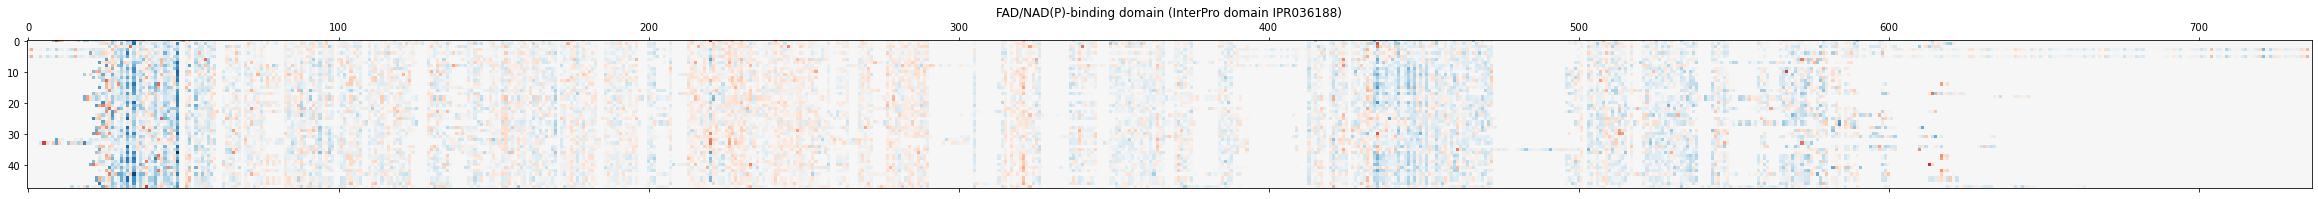

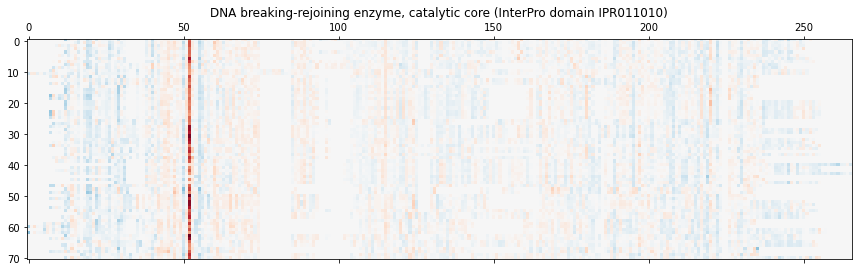

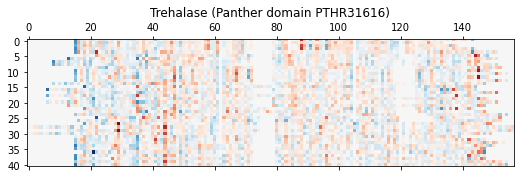

In [12]:
plot_msa("ClusterBbc", "FAD/NAD(P)-binding domain (InterPro domain IPR036188)")
plot_msa("ClusterCtC", "DNA breaking-rejoining enzyme, catalytic core (InterPro domain IPR011010)")
plot_msa("ClusterTaC", "Trehalase (Panther domain PTHR31616)")

In [9]:
import matplotlib.pyplot as plt
from scipy import stats
def plot_impvsconserv(cluster, name):
    msa_tsv = pd.read_csv(f"./Data/{cluster}_merged_unsorted.msa",delimiter="\t", header=None)
    with open(f"./Data/{cluster}.pkl", "rb") as f:
        cluster_data = pickle.load(f)
    consvs = pd.read_csv(f"./Data/{cluster}_msa.consv", delimiter="\t", header=None)
    
    fig, ax = plt.subplots()
    
    data = cluster_data["matrix"][cluster_data["sols"]==0, :]
    insol_scores = np.abs(data.sum(0)) / data.shape[0]
    bin_means, bin_edges, binnumber = stats.binned_statistic(np.arange(data.shape[1]), np.abs(insol_scores),
        statistic='mean', bins=50)
    
    ln1 = ax.plot((bin_edges[:-1] + bin_edges[1:])/2, bin_means, color='red', linestyle='-', label='Insoluble proteins')

    
    data = cluster_data["matrix"][cluster_data["sols"]==1, :]
    sol_scores = np.abs(data.sum(0)) / data.shape[0]
    bin_means, bin_edges, binnumber = stats.binned_statistic(np.arange(data.shape[1]), np.abs(sol_scores),
        statistic='mean', bins=50)
    ln2 = ax.plot((bin_edges[:-1] + bin_edges[1:])/2, bin_means, color='blue', linestyle='-', label='Soluble proteins')
    
    
    ax2 = ax.twinx()
    bin_means, bin_edges, binnumber = stats.binned_statistic(np.arange(data.shape[1]), consvs[1],
        statistic='mean', bins=50)
    ln3 = ax2.plot((bin_edges[:-1] + bin_edges[1:])/2, bin_means, color='gray', linestyle='-', label='Conservation')
    
    
    lns = ln1+ln2+ln3
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=0)
    ax.set_xlabel("Length")
    ax.set_ylabel(r"Importance")
    ax2.set_ylabel(r"Conservation")
    ax.set_title(name)
    
    fig.savefig(f'{cluster}_consvimp.png')

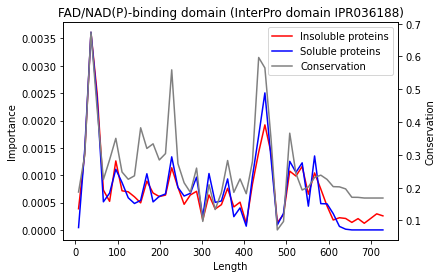

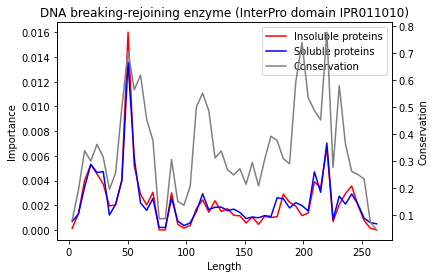

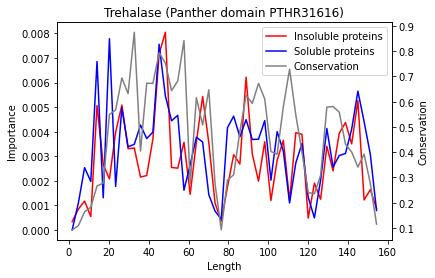

In [10]:
plot_impvsconserv("ClusterBbc", "FAD/NAD(P)-binding domain (InterPro domain IPR036188)")
plot_impvsconserv("ClusterCtC", "DNA breaking-rejoining enzyme (InterPro domain IPR011010)")
plot_impvsconserv("ClusterTaC", "Trehalase (Panther domain PTHR31616)")